In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Loading Data and Pre-processing

In [4]:
file_name = 'proudboys.csv'
data = pd.read_csv(file_name, encoding='ISO-8859-1')
data = data[['user_id', 'status_id', 'text', 'Y/N']]
data['proc_text'] = data['text'].str.lower()
print(data.shape)

(11309, 5)


C:\Users\Fahim\Anaconda3\envs\social_media_mining\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Removing unlabled data

In [5]:
# Remove the unlabeled data
data = data.dropna(subset=['Y/N'])
print(data.shape)

(2014, 5)


In [6]:
data['supportive'] = data['Y/N'].str.contains('Y')
data['offensive'] = data['Y/N'].str.contains('O')
data.head()

,user_id,status_id,text,Y/N,proc_text,supportive,offensive
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,proud boys are attacking peaceful protesters i...,False,False
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,"@medde13 @mrandyngo i live in portland, proud ...",False,False
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",anyone else wondering why trump and his deplor...,False,True
3,x375304364,x1297365456190406662,Not Antifa but the Right Wing Proud Boys. If y...,Y,not antifa but the right wing proud boys. if y...,True,False
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,@marcian2003 @joshuapotash the police and the ...,False,False


Pre-processing Steps:

    1. Lower case
    2. Word tokenize
    3. Removing numbers and punctuations
    4. Word stemming

In [7]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['proc_text'])
    words = [word for word in words if word.isalpha()]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
    data.loc[idx, 'proc_text'] = ' '.join(words)
    

data.head()

,user_id,status_id,text,Y/N,proc_text,supportive,offensive,lem_text
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,proud boy attack peac protest portland portlan...,False,False,proud boy attacking peaceful protester portlan...
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,mrandyngo live portland proud boy white suprem...,False,False,mrandyngo live portland proud boy white suprem...
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",anyon els wonder trump deplor base speak conde...,False,True,anyone else wondering trump deplorable base sp...
3,x375304364,x1297365456190406662,Not Antifa but the Right Wing Proud Boys. If y...,Y,antifa right wing proud boy think far left cau...,True,False,antifa right wing proud boy think far left cau...
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,joshuapotash polic proud boy,False,False,joshuapotash police proud boy


# Word Cloud

In [8]:
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open('cloud.png'))
wc_o = WordCloud(background_color='white', max_words=200, mask=mask)
wc_offensive = wc_o.generate(' '.join(data[data['offensive'] == True]['lem_text']))

wc_no = WordCloud(background_color='white', max_words=200, mask=mask)
wc_nonoffensive = wc_no.generate(' '.join(data[data['offensive'] == False]['lem_text']))

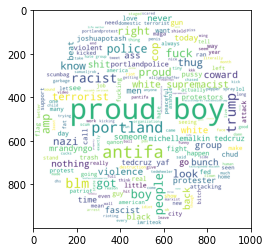

In [9]:
plt.imshow(wc_offensive)

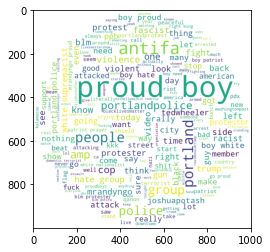

In [10]:
plt.imshow(wc_nonoffensive)

# Linguistic Features

Bag of Words (**X1**)

In [11]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000) # CountVectorizer(ngram_range=(2,2))
X1 = cv.fit_transform(data['proc_text']).toarray()

Term Frequence - Inverse Document Frequency (**X2**)

In [12]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2000)
X2 = cv.fit_transform(data['proc_text']).toarray()

Word2Vec **NOTE**

In [13]:
from gensim.models import Word2Vec
corpus = ' '.join(data['proc_text'])
#print(corpus)
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)
words = model.wv.vocab
print(len(words), len(data['proc_text']))

# To Do

28 2014


WORD EMBEDDING **NOTE**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# To Do

Processing the Labels (**y**)

In [15]:
# Labels for Supportive / Non supportive
y = pd.get_dummies(data['supportive'])
y = y.iloc[:, 1].values
print(y[:6])

[0 0 0 1 0 0]


# Classifiers

Train Test Split (**X_train, y_train, X_test, y_test**)

In [16]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, random_state=0)

Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB().fit(X_train, y_train)

y_pred = model_NB.predict(X_test)

Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=200, criterion='entropy').fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[233  25]
 [ 75  70]]


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print(f'Accuracy: {accuracy*100}%, Precision: {precision*100}%, Recall: {recall*100}%, F1-score: {f1*100}%')

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       258
           1       0.74      0.48      0.58       145

    accuracy                           0.75       403
   macro avg       0.75      0.69      0.70       403
weighted avg       0.75      0.75      0.74       403

Accuracy: 75.18610421836229%, Precision: 73.68421052631578%, Recall: 48.275862068965516%, F1-score: 58.333333333333336%


### Naive Bayes: Accuracy = 0.75, Precision = 0.79, Recall = 0.4, F1-score = 0.53

### Random Forest: Accuracy = 0.76, Precision = 0.75, Recall = 0.50, F1-score = 0.60